# Regresssion with outliers

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plugins import plot_training_data
from plugins import plot_sampled_trace
from plugins import plot_parameter_dist

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

Load the read infer predict layer (ripl) and set venture's random seed to 1 to
ensure reproducibility.

In [4]:
%ripl --seed 42 --plugins plugins.py

Set seed of a new VentureScript RIPL to 42.00.
Loading plugin: plugins.py


## 1. Venture model component

In [5]:
%%venturescript
// MODEL
assume slope     = normal(0, 1) #parameters:0;
assume intercept = normal(0, 1) #parameters:1;
assume noise =  -log_logistic(log_odds_uniform() #parameters:2) * 2;

assume outlier_noise   = 25;
assume outlier_probability = 0.1;
assume is_outlier = mem((i) ~> {
  bernoulli(outlier_probability) #outlierindicators:i });

assume model = (i, x) ~> {
    if (is_outlier(integer(i))) { 
      normal(0, outlier_noise) 
    } else { 
      normal(slope * x + intercept, noise)}};

// Load data                  
define data_xs = load_csv(str_concat(get_path(), "/training_xs.csv"));
define data_ys = load_csv(str_concat(get_path(), "/training_ys.csv")); 
// Helper function:
define get_outlier_assignments = () -> {
  mapv(
      (i) -> run({sample(is_outlier($i))}),
      arange(size(data_xs))
  )  
};

##  Priors

In [6]:
prior = []
for _ in range(100):
    %venturescript reset_to_prior;
    slope         = %venturescript sample slope
    intercept     = %venturescript sample intercept
    inlier_noise  = %venturescript sample noise
    outlier_noise = %venturescript sample outlier_noise
    prior.append([slope, intercept, inlier_noise, outlier_noise])
prior = np.asarray(prior)

##### Keeping outlier noise fixed for now.

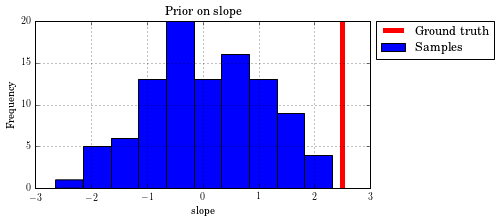

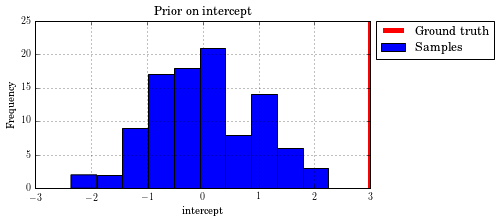

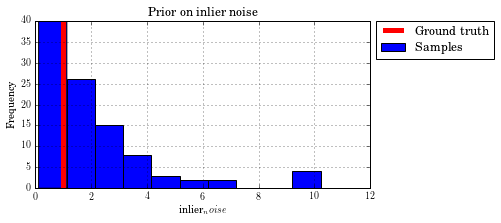

In [7]:
fig, ax = plot_parameter_dist(
    prior[:,0], 'Prior on slope', 'slope'
)
fig, ax = plot_parameter_dist(
    prior[:,1], 'Prior on intercept', 'intercept'
)
fig, ax = plot_parameter_dist(
    prior[:,2], 'Prior on inlier noise', 'inlier_noise'
)

### Plot training data

In [8]:
data_xs = %venturescript data_xs
data_ys = %venturescript data_ys

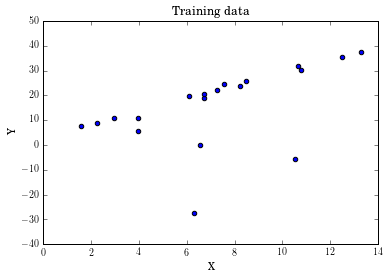

In [9]:
fig, ax = plt.subplots()
ax.scatter(data_xs, data_ys)
ax.set_title('Training data')
ax.set_xlabel('X')
ax.set_ylabel('Y')

## 3. Venture observation component

## 4. Venture infererence components

## 5. Samples from the prior

In [10]:
def plot_trace(title):
    outliers = %venturescript get_outlier_assignments()
    slope      = %venturescript sample slope
    intercept  = %venturescript sample intercept
    std = %venturescript sample noise
    outlier_std = %venturescript sample outlier_noise
    fig, ax = plot_sampled_trace(data_xs, data_ys, outliers, slope, intercept, std, outlier_std)
    #ax.set_title('Sampled trace -- %s' % title)
    return fig, ax

(<matplotlib.figure.Figure at 0x7fd4d11a9890>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd4d1051cd0>)

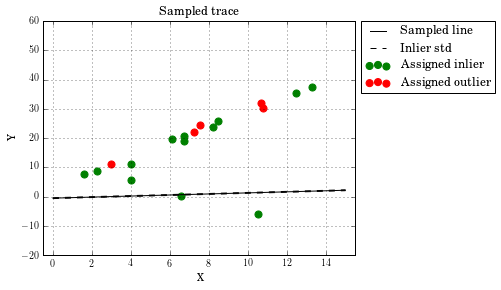

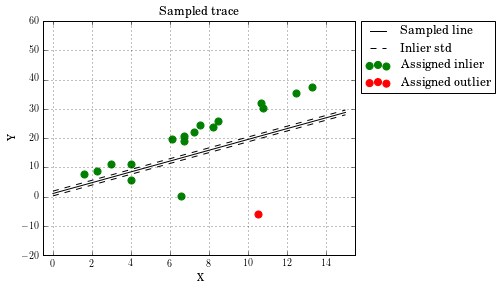

In [11]:
plot_trace('prior')
%venturescript reset_to_prior;
plot_trace('prior')

## Run inference

In [12]:
path = '/home/ulli/git_repos/Venture_semantics/figs/linear-regression/'

In [13]:
def save_figure(f, fname):
    f.get_axes()[0].legend().remove()
    f.set_size_inches((3.5,3))
    f.set_tight_layout(True)
    f.savefig(path + '/%s.pdf' % (fname,))

### Single-variable MH

### Single var MH and Gibbs 

### SMC -- LBFGS &  Gibbs

In [14]:
%%venturescript
define k = 4;
define indeces = shuffle(arange(size(data_xs)));
for_each (arange(k), (i) -> {
    index = indeces[i];
    action(print(index));
    observe model($index, $ {data_xs[index]}) = data_ys[index]});
lbfgs_optimize(minimal_subproblem(random_singleton(/?parameters/ *)));
for_each(arange(k, size(data_xs)),
    (i) -> {
    index = indeces[i];  
    observe model($index, ${data_xs[index]}) = data_ys[index]
});
for_each (arange(size(data_xs)), (i) -> {
    gibbs(minimal_subproblem(/?outlierindicators==i))
})


3.0
15.0
6.0
10.0
An error has occurred:
('Venture value cannot be converted', 'Nil')


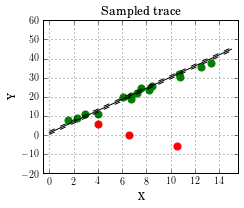

In [15]:
fig, ax = plot_trace('-- after ')
save_figure(fig, 'smc-lbfgs')

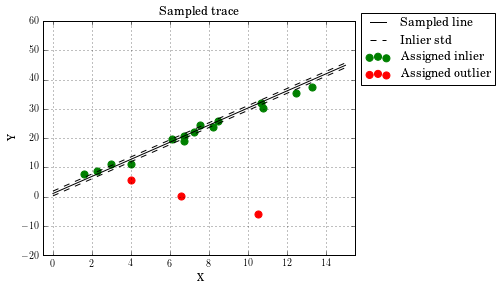

In [20]:
fig, ax = plot_trace('-- after ')
outside={'loc': 'upper left',  'bbox_to_anchor':(1, 1.06)}
legend = ax.legend(**outside)

In [27]:
def export_legend(legend, filename="legend_vertical.pdf", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(path + filename, dpi="figure", bbox_inches=bbox)

In [25]:
export_legend(legend)